**<font color="blue">Llama Model</font>**
<br/>WANDB Project Link : https://wandb.ai/meghacnair96-the-university-of-texas-at-dallas/llama_emotion_detection?nw=nwusermeghacnair96

In [ ]:
# If in Colab, then import the drive module from google.colab
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  # Mount the Google Drive to access files stored there
  drive.mount('/content/drive')

  # Install the latest version of torchtext library quietly without showing output
  # !pip install torchtext -qq
  !pip install transformers evaluate wandb datasets accelerate -U peft bitsandbytes  ## NEW LINES ##
  basepath = '/content/drive/MyDrive/Applied NLP'
else:
  basepath = '/home/harpreet/Insync/google_drive_shaannorr/data'

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 102.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
  Attempting uninstall: wandb
    Found existing installation: wandb 0.18.6
    Uninstalling wandb-0.18.6:
      Successfully uninstalled wandb-0.18.6
ERROR: pip's de

In [ ]:
!apt-get install -y ninja-build

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  ninja-build
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 111 kB of archives.
After this operation, 358 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 ninja-build amd64 1.10.1-1 [111 kB]
Fetched 111 kB in 1s (124 kB/s)
Selecting previously unselected package ninja-build.
(Reading database ... 123629 files and directories currently installed.)
Preparing to unpack .../ninja-build_1.10.1-1_amd64.deb ...
Unpacking ninja-build (1.10.1-1) ...
Setting up ninja-build (1.10.1-1) ...
Processing triggers for man-db (2.10.2-1) ...


**<font color="blue">Step 1: Import the necessary libraries</font>**

In [ ]:
# standard data science librraies for data handling and v isualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
import gc
import time

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score
import joblib

import torch
import torch.nn as nn
import ast


# New libraries introduced in this notebook
import evaluate
from datasets import load_dataset, DatasetDict, Dataset, ClassLabel
from transformers import (
    TrainingArguments,
    Trainer,
    set_seed,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoConfig,
    pipeline,
    BitsAndBytesConfig,
    DataCollatorWithPadding
)
from peft import (
    TaskType,
    LoraConfig,
    prepare_model_for_kbit_training,
    get_peft_model,
)

import wandb
from google.colab import userdata
from huggingface_hub import login
set_seed(42)

**<font color="blue">Step 2: Login to Hugging Face and WAND</font>**

In [ ]:
wandb_api_key = userdata.get('WAND_API_KEY')
hf_token = userdata.get('HF_Token')

In [ ]:
if hf_token:
    # Log in to Hugging Face
    login(token=hf_token)
    print("Successfully logged in to Hugging Face!")
else:
    print("Hugging Face token not found in notebook secrets.")

Successfully logged in to Hugging Face!


In [ ]:
if wandb_api_key:
  wandb.login(key=wandb_api_key)
  print("Successfully logged in to WANDB!")
else:
    print("WANDB key not found in notebook secrets.")


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Successfully logged in to WANDB!


In [ ]:
base_folder = Path(basepath)
data_folder = base_folder/'data'
model_folder = base_folder/'models'
custom_functions = base_folder/'Codes/Custom py classes'

In [ ]:
base_folder


PosixPath('/content/drive/MyDrive/Applied NLP')

**<font color="blue">Step 3: Read data</font>**

In [ ]:
traindata = pd.read_csv(data_folder/'train.csv')
testdata = pd.read_csv(data_folder/'test.csv')

In [ ]:
traindata.head()


,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2017-21441,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,2017-31535,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,2017-21068,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,2017-31436,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,2017-22195,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0


**<font color="blue">Step 4: Since most encoder models can accept only a fixed sequence length it is important to check for the sequence length distribution</font>**

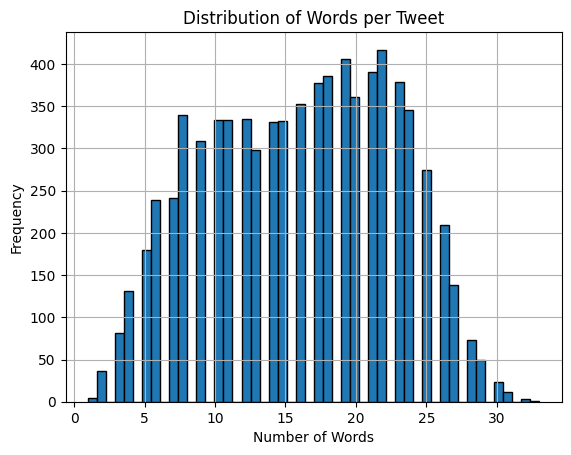

In [ ]:
import matplotlib.pyplot as plt

traindata['Tweet'] =traindata['Tweet'].fillna('')
# Calculate words per review
traindata['words_per_tweet'] = traindata["Tweet"].str.split().apply(len)
# Plot a histogram of the 'words_per_review' column
traindata['words_per_tweet'].hist(bins=50, edgecolor='black')

# Adding labels and a title for clarity
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Words per Tweet')

# Display the plot
plt.show()

**<font color="blue">Step 5: Split the data into training and validation sets</font>**

In [ ]:
from sklearn.model_selection import train_test_split

# Assuming your DataFrame is named df
X = traindata['Tweet']  # Features (the text data)
y = traindata[['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']]  # Labels

# Splitting into 80% train and 20% validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Combine the split sets into DataFrames if needed
train_df = pd.DataFrame({'Tweet': X_train, **y_train})
val_df = pd.DataFrame({'Tweet': X_val, **y_val})

test_df = pd.DataFrame({'Tweet': testdata['Tweet']})



**<font color="blue">Step 6: Create HuggingFace datasets</font>**

In [ ]:
from datasets import Dataset, DatasetDict

# Convert train and validation DataFrames to Hugging Face Dataset objects
train_dataset = Dataset.from_pandas(train_df)
valid_dataset = Dataset.from_pandas(val_df)

# Now create the DatasetDict
train_val = DatasetDict(
    {"train": train_dataset, "valid": valid_dataset}
)


**<font color="blue">Step 7: Import tokensizer and tokenize the data</font>**

In [ ]:
def free_gpu_memory():
    """
    Frees up GPU memory after CUDA out-of-memory error in Colab.

    This function performs the following steps:
    1. Deletes all PyTorch objects to clear references.
    2. Calls garbage collection to remove unreferenced objects from memory.
    3. Uses torch.cuda.empty_cache() to release cached GPU memory.
    4. Waits for a moment to ensure memory is fully released.
    """
    try:
        # Delete all torch tensors to free up memory
        for obj in list(locals().values()):
            if torch.is_tensor(obj):
                del obj

        # Collect garbage to release any remaining unused memory
        gc.collect()

        # Empty the CUDA cache to release GPU memory
        torch.cuda.empty_cache()

        # Adding a small delay to allow memory to be fully released
        time.sleep(2)

        print("GPU memory has been freed.")
    except Exception as e:
        print(f"Error while freeing GPU memory: {e}")


In [ ]:
free_gpu_memory()

GPU memory has been freed.


In [ ]:
checkpoint = "meta-llama/Llama-3.2-1B"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [ ]:
tokenizer.pad_token = '<|finetune_right_pad_id|>'

In [ ]:
def tokenize_fn(batch):
    # Tokenize the text
    tokenized_inputs = tokenizer(batch["Tweet"], truncation=True,  max_length=512)
    # Extract and format the labels as float32
    labels = [
        [float(batch[label][i]) for label in ["anger", "anticipation", "disgust", "fear", "joy",
                                              "love", "optimism", "pessimism", "sadness",
                                              "surprise", "trust"]]
        for i in range(len(batch["Tweet"]))
    ]
    # Add labels to the tokenized inputs
    tokenized_inputs["labels"] = labels
    return tokenized_inputs


In [ ]:
tokenized_dataset= train_val.map(tokenize_fn, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(
    ['Tweet','anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']
)
tokenized_dataset.set_format(type='torch')


Map:   0%|          | 0/6179 [00:00<?, ? examples/s]

Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 6179
    })
    valid: Dataset({
        features: ['__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1545
    })
})

In [ ]:
tokenized_dataset = (tokenized_dataset
          .map(lambda x : {"float_label": x["labels"].to(torch.float)}, remove_columns=["labels"])
          .rename_column("float_label", "labels"))

Map:   0%|          | 0/6179 [00:00<?, ? examples/s]

Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset['train']['labels'][0:3]

tensor([[0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.],
        [1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0.]])

**<font color="blue">Step 8: Check for class imbalance and then calculate the appropriate weights for each label</font>**

In [ ]:
# Calculate the frequency of each class (emotion)
class_counts = traindata[['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']].sum()

# Display the class counts to check for imbalance
print(class_counts)
#We can see that the class distributions are not balanced

anger           2859
anticipation    1102
disgust         2921
fear            1363
joy             2877
love             832
optimism        2291
pessimism        895
sadness         2273
surprise         396
trust            400
dtype: int64


In [ ]:
import torch
def calculate_pos_weights(dataset):
    # Initialize counters for all labels
    num_labels = len(dataset['train']['labels'][0])
    total_positives = [0] * num_labels
    total_negatives = [0] * num_labels

    # Count positives and negatives for each label
    for label_array in dataset['train']['labels']:
        for i, label in enumerate(label_array):
            if label == 1:
                total_positives[i] += 1
            else:
                total_negatives[i] += 1

    # Calculate pos_weight for each label
    pos_weight = [total_negatives[i] / max(total_positives[i], 1) for i in range(num_labels)]
    return torch.tensor(pos_weight)



In [ ]:
pos_weights = calculate_pos_weights(tokenized_dataset)

In [ ]:
pos_weights

tensor([ 1.7018,  6.0216,  1.6576,  4.8403,  1.6657,  8.0734,  2.3256,  7.7274,
         2.4082, 17.9540, 19.0617])

**<font color="blue">Step 9: Import Llama for Sequence Classification</font>**

In [ ]:
def get_appropriate_dtype():
    if torch.cuda.is_available() and torch.cuda.get_device_capability(0) >= (8, 0):
        return torch.bfloat16
    return torch.float16

In [ ]:
torch_data_type = get_appropriate_dtype()
torch_data_type

torch.bfloat16

In [ ]:
bnb_config = BitsAndBytesConfig(
  load_in_4bit=True,
  bnb_4bit_quant_type="nf4",
  bnb_4bit_use_double_quant=True,
  bnb_4bit_compute_dtype=torch_data_type,
  bnb_4bit_quant_storage=torch_data_type,
)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels = 11,
                                                           problem_type="multi_label_classification",
                                                           quantization_config=bnb_config,
                                                           torch_dtype=torch_data_type,
                                                           trust_remote_code=True,)


`low_cpu_mem_usage` was None, now default to True since model is quantized.
Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Get label names directly from your dataset columns
class_names = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']
config = AutoConfig.from_pretrained(checkpoint)
id2label= {id_: label_ for id_, label_ in enumerate(class_names)}
label2id = {label_: id_ for id_, label_ in enumerate(class_names)}
config.id2label = id2label
config.label2id = label2id
model.config = config
model.config.pad_token_id = tokenizer.pad_token_id


In [ ]:
model

LlamaForSequenceClassification(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear4bit(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((20

In [ ]:
def find_linear_layers(model):
    """
    Extracts the unique names of Linear layers from a model.

    Args:
    model (nn.Module): The model from which to extract Linear layer names.

    Returns:
    list: A list of unique names of Linear layers.
    """
    # Convert the model's modules to string
    model_modules = str(model.modules)
    # Pattern to extract names of Linear layers
    pattern = r'\((\w+)\): Linear'
    # Find all occurrences of the pattern
    linear_layer_names = re.findall(pattern, model_modules)
    print(linear_layer_names)
    # Get unique names using a set, then convert back to list
    target_modules = list(set(linear_layer_names))
    return target_modules

In [ ]:
find_linear_layers(model)

['q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj', 'score']


['up_proj',
 'down_proj',
 'o_proj',
 'q_proj',
 'score',
 'v_proj',
 'gate_proj',
 'k_proj']

In [ ]:
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=128,
    lora_alpha=256,
    lora_dropout=0.01,
    bias="all",
    target_modules = ['v_proj',  'q_proj',  'up_proj', 'o_proj', 'down_proj', 'gate_proj','k_proj'])

lora_model = get_peft_model(model, peft_config )
lora_model.print_trainable_parameters()

trainable params: 90,200,064 || all params: 1,326,036,992 || trainable%: 6.8022


In [ ]:
lora_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): LlamaForSequenceClassification(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 2048)
        (layers): ModuleList(
          (0-15): 16 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.01, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=128, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=128, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
         

In [ ]:
for name, param in lora_model.named_parameters():
    print(f"{name}: {param.requires_grad}")


base_model.model.model.embed_tokens.weight: False
base_model.model.model.layers.0.self_attn.q_proj.base_layer.weight: False
base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight: True
base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight: True
base_model.model.model.layers.0.self_attn.k_proj.base_layer.weight: False
base_model.model.model.layers.0.self_attn.k_proj.lora_A.default.weight: True
base_model.model.model.layers.0.self_attn.k_proj.lora_B.default.weight: True
base_model.model.model.layers.0.self_attn.v_proj.base_layer.weight: False
base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight: True
base_model.model.model.layers.0.self_attn.v_proj.lora_B.default.weight: True
base_model.model.model.layers.0.self_attn.o_proj.base_layer.weight: False
base_model.model.model.layers.0.self_attn.o_proj.lora_A.default.weight: True
base_model.model.model.layers.0.self_attn.o_proj.lora_B.default.weight: True
base_model.model.model.layers.0.mlp.ga

In [ ]:
# load training metrices
accuracy = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1','multilabel')
accuracy_flatten = evaluate.load('accuracy')

def compute_metrics(eval_pred):
    # accuracy_metric = evaluate.load('accuracy', 'multilabel')

    logits, labels = eval_pred
    preds = (logits > 0).astype(int)
    accuracy_label = accuracy_flatten.compute(predictions=preds.flatten(), references=labels.flatten())
    accuracy_all = accuracy.compute(predictions=preds, references=labels)
    f1_micro = f1.compute(predictions=preds, references=labels, average='micro')
    f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
    return {'f1_micro':f1_micro['f1'],
            'f1_macro':f1_macro['f1'],
            'accuracy_label':accuracy_label['accuracy'],
             'accuracy_all':accuracy_all['accuracy']}


In [ ]:
# Define the directory where model checkpoints will be saved
model_folder = Path("/content/llama_lora_emotion")
# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)
run_name= 'llama_emotion_detection'

use_fp16 = torch_data_type == torch.float16
use_bf16 = torch_data_type == torch.bfloat16

# Configure training parameters
training_args = TrainingArguments(
    seed = 42,
    # Training-specific configurations
    num_train_epochs=5,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=16,
    # Number of samples per evaluation batch for each device
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=2,
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant":False},
    # torch_empty_cache_steps=5,
    weight_decay=0.01,  # Apply L2 regularization to prevent overfitting
    learning_rate=1e-5,  # Step size for the optimizer during training
    optim='adamw_torch',  # Optimizer,
    lr_scheduler_type="linear",  # Choose the scheduler type (e.g., "linear", "cosine")
    warmup_steps=200,  # Number of steps to increase learning rate gradually before decaying

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    eval_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=50,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=50,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher
    logging_strategy='steps',
    logging_steps=50,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name= run_name,  # Experiment name for Weights & Biases

    # Precision settings determined based on GPU capability
    fp16=use_fp16 ,  # Set True if torch_data_type is torch.float16
    bf16=use_bf16,  # Set True if torch_data_type is torch.bfloat16
    tf32=False,  # Disable tf32 unless you want to use Ampere specific optimization
)


In [ ]:
# If gradient checkpointing is enabled, configure relevant settings
if training_args.gradient_checkpointing:
    lora_model.config.use_cache = False  # Disable caching for compatibility

lora_model.config

LlamaConfig {
  "_name_or_path": "meta-llama/Llama-3.2-1B",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128001,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "id2label": {
    "0": "anger",
    "1": "anticipation",
    "2": "disgust",
    "3": "fear",
    "4": "joy",
    "5": "love",
    "6": "optimism",
    "7": "pessimism",
    "8": "sadness",
    "9": "surprise",
    "10": "trust"
  },
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "label2id": {
    "anger": 0,
    "anticipation": 1,
    "disgust": 2,
    "fear": 3,
    "joy": 4,
    "love": 5,
    "optimism": 6,
    "pessimism": 7,
    "sadness": 8,
    "surprise": 9,
    "trust": 10
  },
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pad_token_id": 128004,
  "pretraining_tp"

**<font color="blue">Step 10: To account for pos_weights we redefine the compute_loss function of the trainer and create a Customtrainer</font>**

In [ ]:
# initialize trainer
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels").float()  # Ensure labels are float for BCE loss
        outputs = model(**inputs)
        logits = outputs.get("logits")

        device = next(model.parameters()).device

        loss_fct = nn.BCEWithLogitsLoss(pos_weight=pos_weights.to(device))
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss


In [ ]:
# lora_model.config.use_cache = False
trainer = CustomTrainer(
    model=lora_model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["valid"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

<ipython-input-139-fcc51a4c04a4>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


In [ ]:
%env WANDB_PROJECT = llama_emotion_detection

env: WANDB_PROJECT=llama_emotion_detection


In [ ]:
try:
    # Your code that may cause a CUDA out-of-memory error
    # Example: trainer.train() or other GPU intensive operations
    # lora_model.config.use_cache = False
    trainer.train()
except RuntimeError as e:
    if 'CUDA out of memory' in str(e):
        print("CUDA out of memory error detected. Freeing GPU memory.")
        free_gpu_memory()
        trainer.train()
    else:
        raise e


Step,Training Loss,Validation Loss,F1 Micro,F1 Macro,Accuracy Label,Accuracy All
50,1.470900,1.370619,0.293103,0.274047,0.478906,0.000647
100,1.246100,1.186354,0.352221,0.314989,0.564107,0.000647
150,1.104300,1.000384,0.462038,0.417082,0.648956,0.007767
200,0.892400,0.878963,0.519134,0.480323,0.690203,0.014239
250,0.790000,0.827684,0.560765,0.510509,0.745866,0.045955
300,0.746500,0.772091,0.575126,0.530013,0.756575,0.062136
350,0.686200,0.746382,0.607181,0.551997,0.782407,0.078317
400,0.686700,0.725703,0.608796,0.559996,0.779641,0.077670
450,0.599800,0.750395,0.627079,0.565404,0.800824,0.095793
500,0.591900,0.739894,0.611728,0.559710,0.781818,0.064078


**From the above training output we can see that the best F1-score is achieved at step 700, but looking at the training loss and validation loss it makes more sense to pick the model at step 500-600, as post that we can see increases in Training and validation loss increases post that. But since our aim is to get the best f1 and the evaluation is based on f1 lets pick the model at 700. Further changes to hyper parameters like learning rate and weight decay can be adjusted to get consistent and better results in future.**

In [ ]:
# After training, let us check the best checkpoint
# We need this for Inference
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f"The best model was saved at step {best_model_checkpoint_step}.")

The best model was saved at step 700.


**<font color="blue">Step 11: Calculate the optimal thresholds for all the labels.</font>**

In [ ]:
from scipy.special import expit as sigmoid
valid_output = trainer.predict(tokenized_dataset["valid"])

# Get probabilities from logits
valid_logits = valid_output.predictions
valid_probs = sigmoid(valid_logits)
valid_labels = np.array(valid_output.label_ids.astype(int))

In [ ]:
def find_best_thresholds_multilabel(probabilities, labels):
    """
    Find best threshold for each label that maximizes F1 score

    Args:
        probabilities: Array of shape (n_samples, n_labels) with predicted probabilities
        labels: Array of shape (n_samples, n_labels) with true binary labels

    Returns:
        thresholds: List of best thresholds for each label
        metrics: Dictionary containing best F1, precision, and recall for each label
    """
    n_labels = labels.shape[1]
    best_thresholds = []
    metrics = {}

    for label_idx in range(n_labels):
        # Get scores and labels for this label
        label_scores = probabilities[:, label_idx]
        label_true = labels[:, label_idx]

        # Sort by scores
        rows = list(zip(label_scores, label_true))
        rows = sorted(rows, key=lambda x: x[0], reverse=True)

        # Initialize metrics
        best_f1 = best_precision = best_recall = 0
        threshold = 0

        # Count total positives for this label
        total_positives = sum(label_true)

        # Initialize counters
        total_predicted_positives = 0
        true_positives = 0

        # print(f"\nAnalyzing label {label_idx}")

        # Try different thresholds
        for i in range(len(rows) - 1):
            score, label = rows[i]
            total_predicted_positives += 1
            if label == 1:
                true_positives += 1

            if true_positives > 0:
                precision = true_positives / total_predicted_positives
                recall = true_positives / total_positives
                f1 = 2 * precision * recall / (precision + recall)

                # Update best metrics if current F1 is better
                if f1 > best_f1:
                    best_f1 = f1
                    best_precision = precision
                    best_recall = recall
                    threshold = (rows[i][0] + rows[i + 1][0]) / 2

                    # print(f"New best threshold found: {threshold:.3f}")
                    # print(f"F1: {best_f1:.3f}, Precision: {best_precision:.3f}, Recall: {best_recall:.3f}")

        best_thresholds.append(threshold)
        metrics[label_idx] = {
            'f1': best_f1,
            'precision': best_precision,
            'recall': best_recall,
            'threshold': threshold
        }


    return best_thresholds, metrics



In [ ]:
optimal_thresholds, metrics = find_best_thresholds_multilabel(valid_probs, valid_labels)


In [ ]:
optimal_thresholds

[0.4640514552593231,
 0.6334102749824524,
 0.40403783321380615,
 0.7461276054382324,
 0.6570950746536255,
 0.8832335472106934,
 0.5214711427688599,
 0.5929023027420044,
 0.5843895673751831,
 0.867479681968689,
 0.3974706530570984]

In [ ]:
f1 = evaluate.load('f1','multilabel')
def compute_metrics(eval_pred, thresholds):
    # accuracy_metric = evaluate.load('accuracy', 'multilabel')

    logits, labels = eval_pred
    probs = sigmoid(logits)
    preds = (probs > thresholds).astype(int)
    f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
    return {'f1_macro':f1_macro['f1']}


In [ ]:
compute_metrics((valid_logits, valid_labels), optimal_thresholds)

{'f1_macro': 0.6031904646455081}

**We can see a significant increase in f1-score when we use optimal-thresholds as we are not generalizing each labels to a default cutoff of 0.5**

**<font color="blue">Step 11: Confusion matrics for each label</font>**

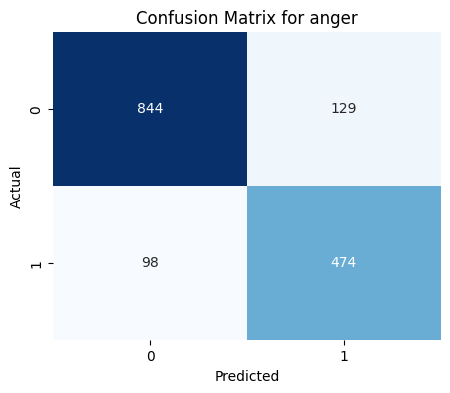

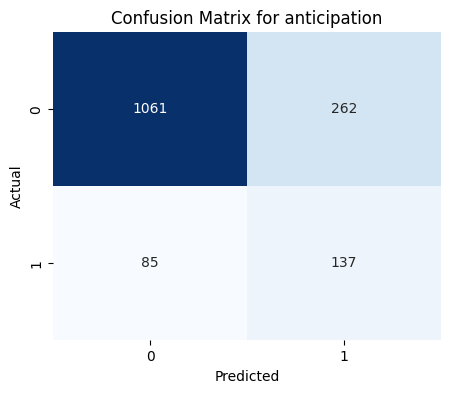

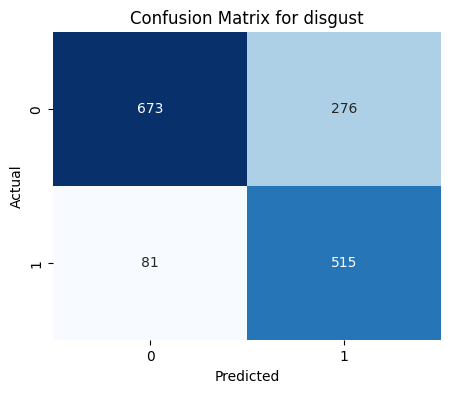

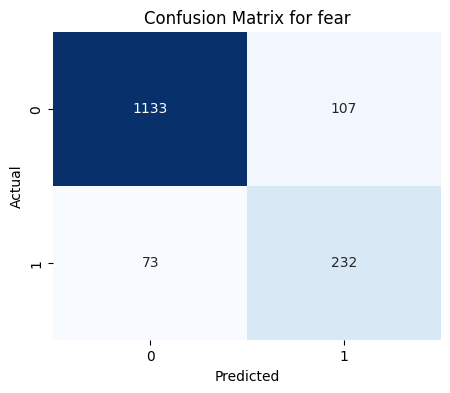

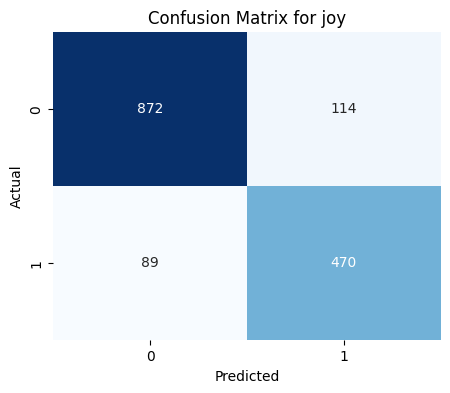

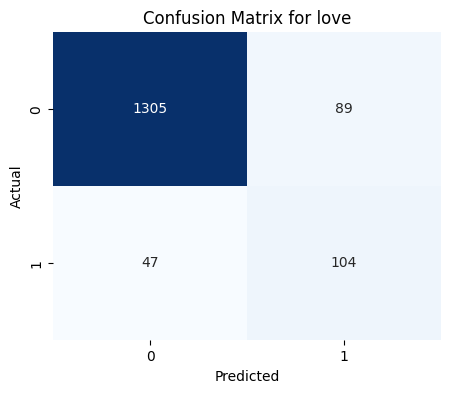

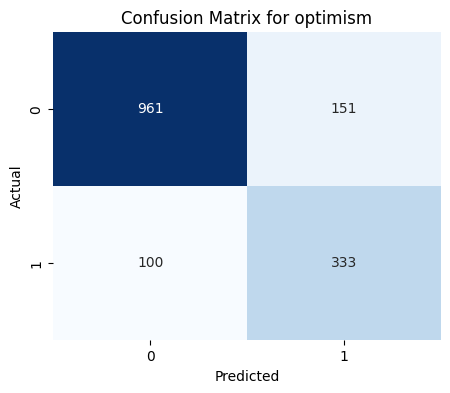

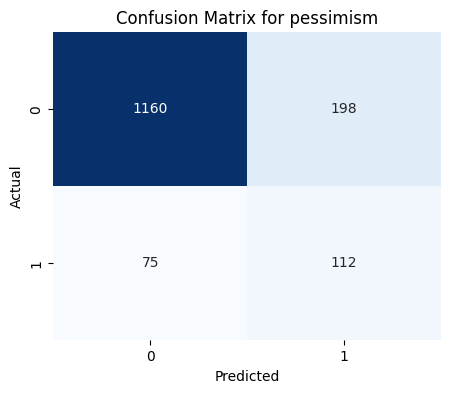

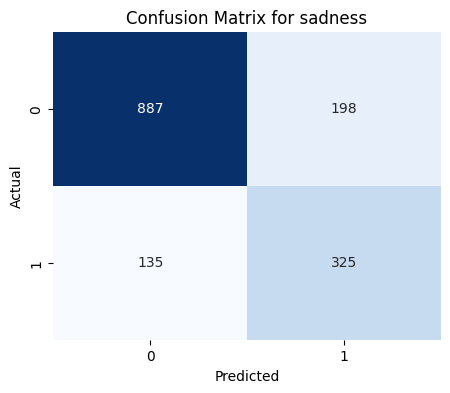

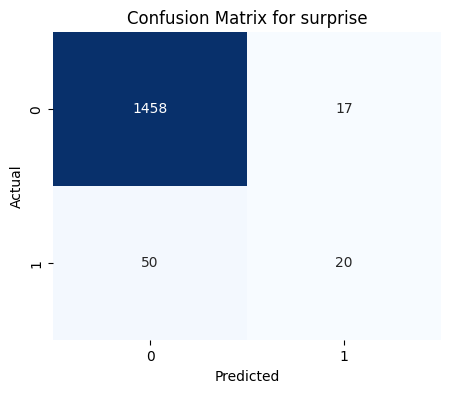

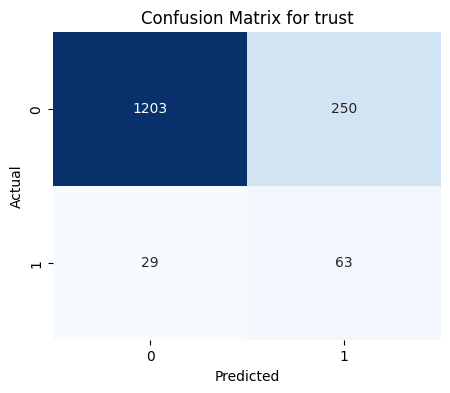

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

label_names = ["anger", "anticipation", "disgust", "fear", "joy",
               "love", "optimism", "pessimism", "sadness", "surprise", "trust"]

# Extract label values into a 2D NumPy array
true_labels = valid_dataset.select_columns(label_names)  # Select the columns in label_names
true_labels = np.array([[row[label] for label in label_names] for row in true_labels])  # Correctly extract label values

# Convert probabilities to binary predictions
predictions = (valid_probs > optimal_thresholds).astype(int)

# Plot confusion matrix for each label
for i, label in enumerate(label_names):
    # Get confusion matrix for the specific label
    cm = confusion_matrix(true_labels[:, i], predictions[:, i])  # Using numpy arrays for true_labels and predictions
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix for {label}")
    plt.show()

**The above outputs show the confusion matrices for each label, which can be used to target specific label performances**

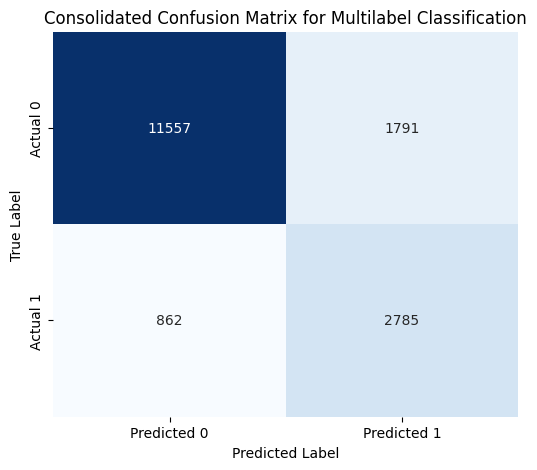

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

label_names = ["anger", "anticipation", "disgust", "fear", "joy",
               "love", "optimism", "pessimism", "sadness", "surprise", "trust"]

# Extract the true labels and predictions
true_labels = valid_dataset.select_columns(label_names)
true_labels = np.array([[row[label] for label in label_names] for row in true_labels])

# Get predictions from the trainer and convert logits to binary predictions
predictions = (valid_probs >optimal_thresholds).astype(int)

# Initialize a 2x2 matrix to accumulate confusion matrix counts
consolidated_cm = np.array([[0, 0], [0, 0]])

# Calculate confusion matrix for each label and sum them
for i in range(len(label_names)):
    cm = confusion_matrix(true_labels[:, i], predictions[:, i])
    consolidated_cm += cm

# Plot the consolidated confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(consolidated_cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Consolidated Confusion Matrix for Multilabel Classification")
plt.show()


**<font color="blue">Step 12: Model inference</font>**

In [ ]:
checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')
checkpoint

'/content/llama_lora_emotion/checkpoint-800'

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,
                                                               num_labels = 11,
                                                           problem_type="multi_label_classification",
                                                           quantization_config=bnb_config,
                                                           torch_dtype=torch_data_type,
                                                           trust_remote_code=True,)

`low_cpu_mem_usage` was None, now default to True since model is quantized.
Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from peft import AutoPeftModelForSequenceClassification, PeftConfig
peft_config = PeftConfig.from_pretrained(checkpoint)
base_model_name = peft_config.base_model_name_or_path
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
tokenizer.pad_token = '<|finetune_right_pad_id|>'

# 3. Set model to evaluation mode
model.eval()
model.config.use_cache = False
model.config.pad_token_id = tokenizer.pad_token_id

In [ ]:
tokenizer.pad_token = '<|finetune_right_pad_id|>'

In [ ]:
def tokenize_test_fn(batch):
    # Tokenize the text
    tokenized_inputs = tokenizer(batch["Tweet"], truncation=True, max_length=512)
    return tokenized_inputs

In [ ]:
test_df = pd.DataFrame({'Tweet': testdata['Tweet']})
testdataset = Dataset.from_pandas(test_df)
tokenised_test = testdataset.map(tokenize_test_fn, batched=True)

Map:   0%|          | 0/3259 [00:00<?, ? examples/s]

In [ ]:
tokenised_test

Dataset({
    features: ['Tweet', 'input_ids', 'attention_mask'],
    num_rows: 3259
})

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    per_device_eval_batch_size=128,
    do_train=False,
    do_eval=True,
    report_to=[],
    run_name=run_name
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=tokenised_test,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

<ipython-input-79-dd1575c7edfc>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
import pandas as pd
import numpy as np

# Run predictions
predictions_output = trainer.predict(tokenised_test)

# Get the raw logits
logits = predictions_output.predictions

# Apply sigmoid to get probabilities for multilabel classification
probs = 1 / (1 + np.exp(-logits))
# Convert probabilities to binary predictions with a threshold of 0.5
predictions = (probs >= optimal_thresholds).astype(int)

# Convert predictions to a DataFrame
predictions_df = pd.DataFrame(predictions, columns=["anger", "anticipation", "disgust", "fear", "joy",
                                                    "love", "optimism", "pessimism", "sadness", "surprise", "trust"])
predictions_df = pd.concat([testdata['ID'], predictions_df], axis=1)
predictions_df.head()

,ID,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-01559,1,0,0,1,0,0,1,0,0,0,0
1,2018-03739,0,0,1,1,0,0,0,0,0,0,0
2,2018-00385,1,0,1,0,0,0,0,0,1,0,0
3,2018-03001,0,0,0,1,0,0,0,1,1,0,0
4,2018-01988,0,0,0,1,0,0,0,1,1,0,0


In [ ]:
# Save predictions to CSV
predictions_df.to_csv("predictions_llama.csv", index=False)
print("Predictions saved to predictions_llama.csv")


Predictions saved to predictions_llama.csv
